# Name: Tousif Tarik
# Id: 23-53577-3
# Section: E

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/CVPR"


animal_dataset


In [ ]:
data_dir = "/content/drive/MyDrive/CVPR/animal_dataset"


In [ ]:
import os, glob
import cv2
import numpy as np

IMG_SIZE = 32


data_dir = "/content/drive/MyDrive/CVPR/animal_dataset"

X = []
y = []
class_names = sorted(os.listdir(data_dir))

print("Classes:", class_names)

for label, cls in enumerate(class_names):
    folder = os.path.join(data_dir, cls)
    for img_path in glob.glob(os.path.join(folder, "*")):
        img = cv2.imread(img_path)
        if img is None:
            continue

        # BGR -> GRAY
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Resize 32x32
        gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        # Flatten -> 1024 dimension
        X.append(gray.flatten())
        y.append(label)

X = np.array(X, dtype=np.float32)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels:", np.unique(y))


Classes: ['cat', 'dog', 'panda']
X shape: (300, 1024)
y shape: (300,)
Unique labels: [0 1 2]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (240, 1024) Test: (60, 1024)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = [1, 3, 5, 7, 9]
distances = ['euclidean', 'manhattan']

results = {dist: [] for dist in distances}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for dist in distances:
    print(f"\nDistance metric: {dist}")
    for k in k_values:
        fold_acc = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
            knn.fit(X_tr, y_tr)
            y_pred = knn.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            fold_acc.append(acc)

        mean_acc = np.mean(fold_acc)
        results[dist].append(mean_acc)
        print(f"K = {k}, mean CV accuracy = {mean_acc:.4f}")



Distance metric: euclidean
K = 1, mean CV accuracy = 0.3375
K = 3, mean CV accuracy = 0.3208
K = 5, mean CV accuracy = 0.3042
K = 7, mean CV accuracy = 0.3083
K = 9, mean CV accuracy = 0.3250

Distance metric: manhattan
K = 1, mean CV accuracy = 0.3458
K = 3, mean CV accuracy = 0.3417
K = 5, mean CV accuracy = 0.3083
K = 7, mean CV accuracy = 0.3500
K = 9, mean CV accuracy = 0.3750


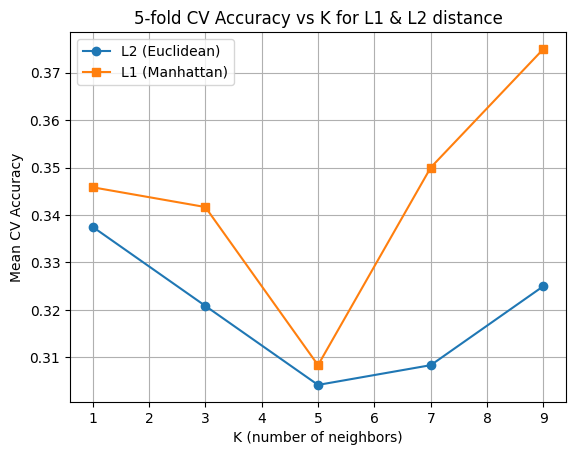

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(k_values, results['euclidean'], marker='o', label='L2 (Euclidean)')
plt.plot(k_values, results['manhattan'], marker='s', label='L1 (Manhattan)')
plt.xlabel("K (number of neighbors)")
plt.ylabel("Mean CV Accuracy")
plt.title("5-fold CV Accuracy vs K for L1 & L2 distance")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
best_acc = 0
best_k = None
best_dist = None

for dist in distances:
    for i, k in enumerate(k_values):
        acc = results[dist][i]
        if acc > best_acc:
            best_acc = acc
            best_k = k
            best_dist = dist

print("Best distance:", best_dist)
print("Best K:", best_k)
print("Best CV accuracy:", best_acc)


Best distance: manhattan
Best K: 9
Best CV accuracy: 0.375


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

best_knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_dist)
best_knn.fit(X_train, y_train)

y_test_pred = best_knn.predict(X_test)

print("Test classification report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))


Test classification report:
              precision    recall  f1-score   support

         cat       0.52      0.65      0.58        20
         dog       0.47      0.75      0.58        20
       panda       1.00      0.15      0.26        20

    accuracy                           0.52        60
   macro avg       0.66      0.52      0.47        60
weighted avg       0.66      0.52      0.47        60



True: dog, Predicted: dog


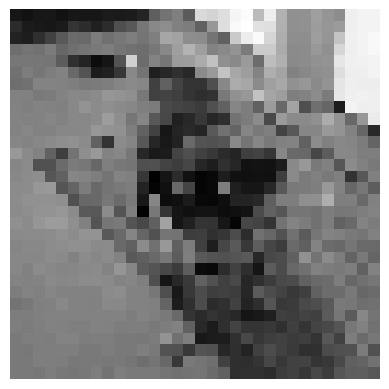

True: dog, Predicted: cat


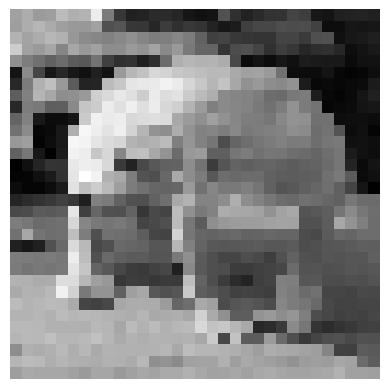

True: dog, Predicted: dog


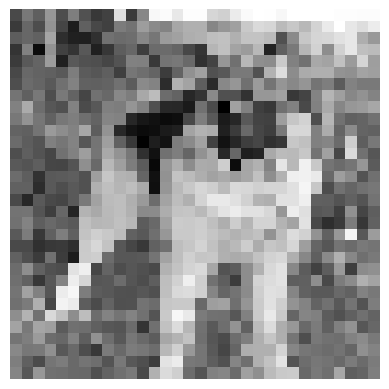

True: cat, Predicted: cat


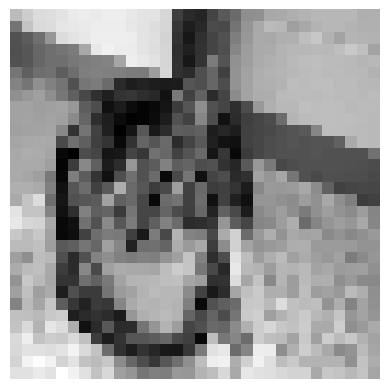

True: cat, Predicted: cat


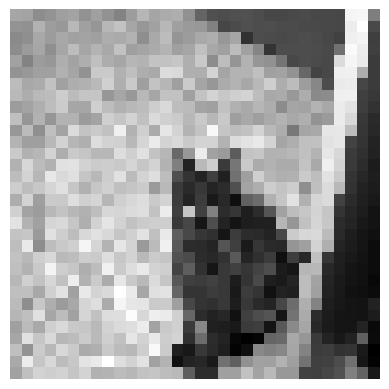

In [ ]:
import random

IMG_SIZE = 32

indices = random.sample(range(len(X_test)), 5)

for idx in indices:
    img_vec = X_test[idx]
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_test_pred[idx]]

    print(f"True: {true_label}, Predicted: {pred_label}")

    plt.imshow(img_vec.reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.axis('off')
    plt.show()
